In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
import string
import wfdb

np.set_printoptions(suppress=True,precision=10)

In [2]:
def obtainMeasures(dbname="mimic",unlimit=False,centroid=None) :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if unlimit else " LIMIT 10000 "
    null = " AND centroid is null" if centroid is None else "AND centroid IS NOT NULL" if centroid =="notNull" else "" 
    select_stament = ("SELECT DISTINCT qt,ts,sr,centroid FROM rstq "
                      " WHERE qt IS NOT NULL "
                      " AND qt > 0 "
                      " AND ts IS NOT NULL "
                      " AND sr IS NOT NULL "+null+limit)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        if centroid  =="notNull" :
            waves.append([qt,ts,sr,row[3]])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    return waves

In [3]:
fig_size = [12,9]
plt.rcParams["figure.figsize"] = fig_size
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    plt.xticks(indexes + width * 0.01, labels)
    plt.show()

In [4]:
waves = obtainMeasures(centroid="all",unlimit=True)
X = np.array(waves)

In [5]:
centroid=np.array([
    [61.8053426046,32.2787555518,23.118412623]
    ,[21.6078916954,72.8152963513,31.9357045567]
    ,[144.8370126103,32.3604470092,14.1864370554]
    ,[271.6645211372,31.0926998092,14.8024064431]
    ,[445.1792934903,28.9046878471,15.2207657558]
    ,[25.8738705513,83.0490503411,350.6367324359]
    ,[725.530715005,25.9460221551,13.7321248741]
    ,[21.620352867,416.3456206679,98.9187145558]])
kmeans = KMeans(n_clusters=8
                ,init=centroid,n_init=1
               ).fit(X)

In [6]:
centroid = kmeans.cluster_centers_
print(centroid)

[[  61.8402675767   32.2802500073   23.1060154382]
 [  21.6121569515   72.7776242809   31.9424421122]
 [ 144.8643425656   32.3534426129   14.1838402664]
 [ 271.6617285547   31.0931556476   14.798906715 ]
 [ 445.1728376776   28.9038062796   15.2287470379]
 [  25.8738705513   83.0490503411  350.6367324359]
 [ 725.530715005    25.9460221551   13.7321248741]
 [  21.6375944584  416.2367758186   98.9011335013]]


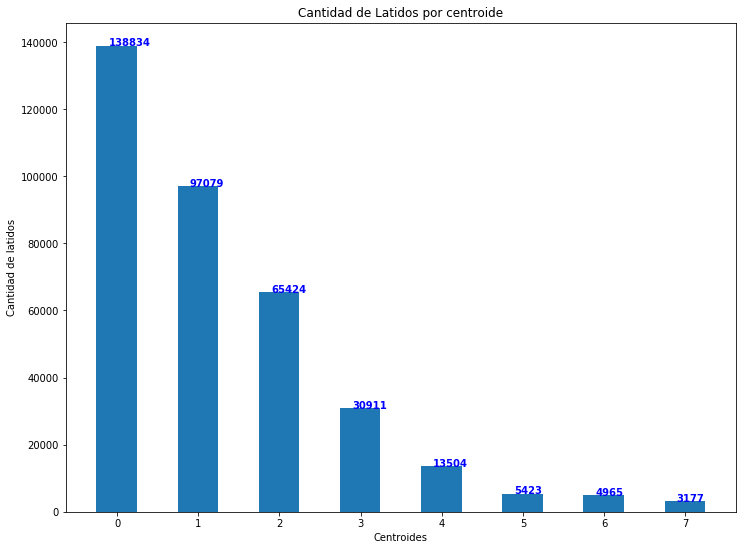

In [7]:
printKmeans(kmeans)

In [8]:
def updateQRST(wacentroid) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = """
    UPDATE rstq AS t
    SET
        centroid = s.centroid
        FROM unnest(%s) s(qt integer,ts integer,sr integer,centroid unknown)
        WHERE t.qt = s.qt
        AND t.ts = s.ts
        AND t.sr = s.sr;
    """
#    print(cur.mogrify(select_stament, (wacentroid,)))
    cur.execute(select_stament, (wacentroid,))
    conn.commit()
    conn.close()

In [9]:
def fillEmptyCentroids(iterations=1280) :
    waves = obtainMeasures(unlimit=True,centroid=None)
    print("measures obtained:"+str(len(waves)))
    waves = waves[:iterations] if iterations<len(waves) else waves
    numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))
    i = 1
    centro = []
    for wave in waves :
        try:
            centValue = numberToAlpha[kmeans.predict([[wave[0],wave[1],wave[2]]])[0]]
            centro.append((wave[0],wave[1],wave[2],str(centValue)))
        except:
            print("error in value")
        i=i+1
    if centro != [] :
        updateQRST(centro)

In [10]:
fillEmptyCentroids(102400)

measures obtained:0


In [11]:
def centroidColor(clist) :
    color = {
        'a': "blue",
        'b': "red",
        'c': "green",
        'd': "magenta",
        'e': "cyan",
        'f': "yellow",
        'g': "limegreen", 
        'h': "pink",
        None : "maroon"
    }
    return [color[x] for x in clist]

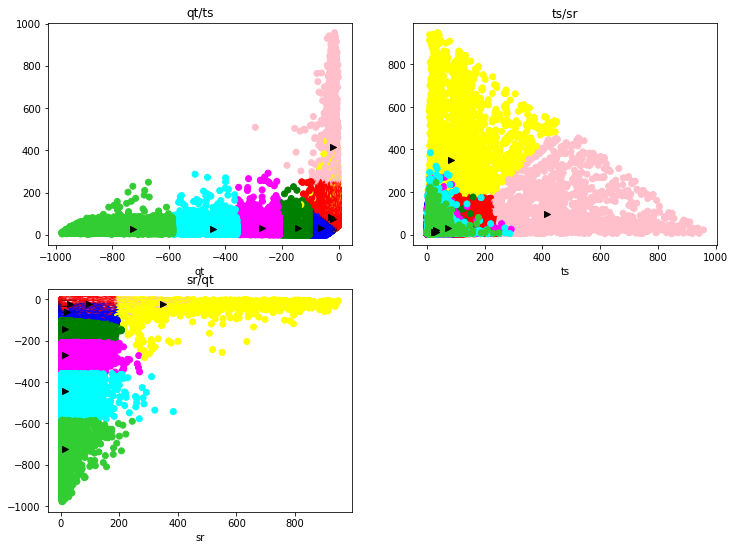

In [12]:
waves = obtainMeasures(unlimit=True,centroid="notNull")
qt = np.array([-item[0] for item in waves])
ts = np.array([item[1] for item in waves])
sr = np.array([item[2] for item in waves])
color = np.array([item[3] for item in waves])
qtc = np.array([-int(item[0]) for item in centroid])
tsc = np.array([item[1] for item in centroid])
src = np.array([item[2] for item in centroid])
color = centroidColor(color)
fig = plt.figure()
ax = fig.add_subplot(221)
ax.set_title("qt/ts")
ax.set_xlabel("qt")
ax.scatter(qt,ts, c=color)
ax.scatter(qtc,tsc,c='black', marker=">")
ax = fig.add_subplot(222)
ax.set_title("ts/sr")
ax.set_xlabel("ts")
ax.scatter(ts,sr, c=color)
ax.scatter(tsc,src,c='black', marker=">")
ax = fig.add_subplot(223)
ax.set_title("sr/qt")
ax.set_xlabel("sr")
ax.scatter(sr,qt, c=color)
ax.scatter(src,qtc,c='black', marker=">")
plt.show()

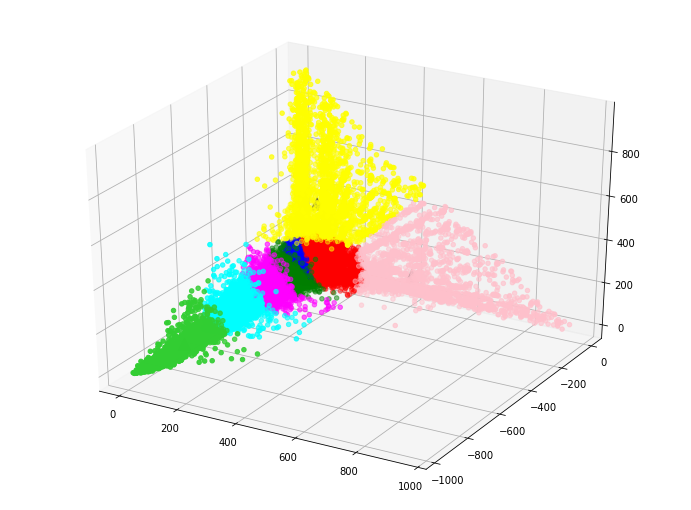

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts,qt, sr, c=color)
ax.scatter(tsc,qtc, src, c='black',marker="^",s=160)
plt.show()

In [14]:
def findCentroid(centroid,window=0,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    qt = str(centroid[0])
    ts = str(centroid[1])
    sr = str(centroid[2])
    strWin = str(window)
    select_stament = ("SELECT rstq.record,r_s,q_s,a.rec_from,a.rec_to,wave,centroid "
                      " FROM rstq LEFT JOIN a ON a.record=rstq.record  "
                      " WHERE "
                      " (qt between floor("+qt+")-"+strWin+" and ceil("+qt+")+"+strWin+")"
                      " AND (ts between floor("+ts+")-"+strWin+" and ceil("+ts+")+"+strWin+")"
                      " AND (sr between floor("+sr+")-"+strWin+" and ceil("+sr+")+"+strWin+")"
                      " AND rstq.record not in ('mimic2wdb/matched/s23890/s23890-2832-10-25-12-55',"
                      " 'mimic2wdb/matched/s20486/s20486-2701-07-11-18-41') "
                      " LIMIT 1")
    cur.execute(select_stament)
    notFound = True
    for row in cur :
        notFound = False
        pbdir = row[0]
        wave = pbdir.split("/")[3]
        pbdir = pbdir.replace("/"+wave,'')
        return {"pbdir":pbdir,"onda":wave,"r_s":row[1],"q_s":row[2],"rec_from":row[3],"rec_to":row[4],"wave":row[5],"centroid":row[6]}
    if(notFound) :
        return findCentroid(value,window=window+1)

In [15]:
def updateOriginalWave(wave,originalWave):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = ("UPDATE rstq SET wave = (%s) "
                      "WHERE record = (%s) AND r_s = (%s) AND q_s = (%s)")
    record=wave['pbdir']+"/"+wave['onda']
    print(record+"r_s"+str(wave['r_s']))
    cur.execute(select_stament, (originalWave.tolist(),record,wave['r_s'],wave['q_s'],))
    conn.commit()
    cur.close()
    conn.close()

In [16]:
def printCentroid(wave) :
    onda = wave['onda']
    originalWave = wave['wave']
    if originalWave is None :
        sig, fields = wfdb.srdsamp(onda,pbdir=wave['pbdir'], sampto=1)
        signalII = fields['signame'].index("II")
        sfrom = wave['rec_from']+wave['r_s']-20
        sto   = wave['rec_from']+wave['q_s']
        #sto = sfrom+100 if sto-sfrom>100 else sto
        originalWave = wfdb.rdsamp(onda,pbdir=wave['pbdir'],channels =[signalII], sampfrom=sfrom, sampto=sto).p_signals
        originalWave = originalWave[~np.isnan(originalWave)]
        updateOriginalWave(wave,originalWave)
    ax.set_title(wave['centroid'])
    ax.plot(originalWave[:100])

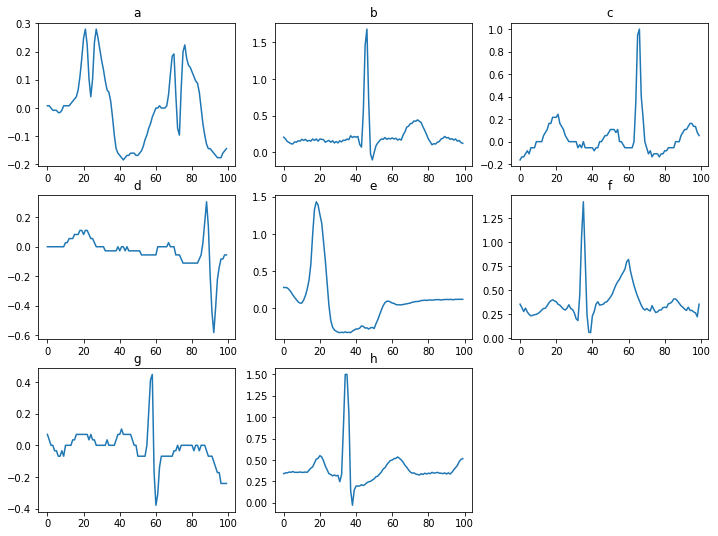

In [17]:
fig = plt.figure()
inx= 1
for value in centroid :
    ax = fig.add_subplot(3,3,inx)
    wave = findCentroid(value)
#    print("wave",wave)
    printCentroid(wave)
    inx=inx+1
plt.show()